# Capstone Project - The Battle of the Neighborhoods (Week 1)
### Applied Data Science Capstone by IBM/Coursera

## 1. Introduction

Toronto is a big city and Canada's biggest city. Toronto is considered one of the most culturally diverse cities in the world, with more than half the population born outside of the city

I want to explore and extract the similarity and disimilarity of each area (Postal Code) in Toronto that can help tourists who want to visit Toronto by providing insight.

## 2. DATA

I will use machine learning technique to segment the area which are similar based on
* number of each existing Venue Category in the area within 500 meter from Center Point of the area

In [117]:
import pandas as pd
import requests
import folium

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [118]:
!pip install folium

### 3. Data preprocessing

In [119]:
Toronto = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]

# Drop `NaN` and `Not assigned`
Toronto = Toronto[ Toronto['Borough'].notna() & (Toronto['Borough'] != 'Not assigned') ]
# Reset Index
Toronto = Toronto.reset_index(drop=True)
# If Neighborhood is Nan, fill with Borough
Toronto.Neighborhood.fillna(Toronto.Borough, inplace=True)

LatLongToronto = pd.read_csv("https://cocl.us/Geospatial_data")

Toronto = Toronto.set_index('Postal Code').join( LatLongToronto.set_index('Postal Code') ).reset_index()

Toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Map

In [120]:
# Toronto
latitude = 43.651070
longitude = -79.347015
TorontoMap = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, label in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Postal Code']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(TorontoMap)  
    
TorontoMap

In [121]:
CLIENT_ID = 'IKU0SZMHOXR45B42XVDJU1QWCDNMFBCZSPEQ5QUZUK13IMHX'
CLIENT_SECRET = 'JG25RHSYJG4XU4JTKBV3C3LW30NWLRJL5G4Q0XE4N2RNJX2N'
VERSION = '20200625'
LIMIT = 100
radius = 500

In [122]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append(
            [(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results
            ])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [ 
        'District', 
        'District Latitude', 
        'District Longitude', 
        'Venue', 
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue Category'
    ]
    
    return nearby_venues

### 3.1 getNearbyVenues

In [123]:
TorontoVenue = getNearbyVenues( names=Toronto['Postal Code'], latitudes=Toronto['Latitude'], longitudes=Toronto['Longitude'] )

In [124]:
TorontoVenue.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,M3A,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,M4A,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [125]:
TorontoVenue["Venue Category"].unique()

array(['Park', 'Food & Drink Shop', 'Construction & Landscaping',
       'Hockey Arena', 'Portuguese Restaurant', 'Coffee Shop',
       'Intersection', 'Pizza Place', 'Bakery', 'Distribution Center',
       'Spa', 'Pub', 'Restaurant', 'Breakfast Spot',
       'Gym / Fitness Center', 'Historic Site', 'Farmers Market',
       'Performing Arts Venue', 'Chocolate Shop', 'Dessert Shop',
       'French Restaurant', 'Café', 'Yoga Studio', 'Theater',
       'Event Space', 'Shoe Store', 'Ice Cream Shop', 'Art Gallery',
       'Cosmetics Shop', 'Asian Restaurant', 'Electronics Store', 'Bank',
       'Beer Store', 'Antique Shop', 'Boutique', 'Furniture / Home Store',
       'Vietnamese Restaurant', 'Clothing Store', 'Accessories Store',
       "Women's Store", 'Miscellaneous Shop', 'Arts & Crafts Store',
       'Athletics & Sports', 'Italian Restaurant', 'Sushi Restaurant',
       'Creperie', 'Beer Bar', 'Burrito Place', 'Mexican Restaurant',
       'Hobby Shop', 'Diner', 'Fried Chicken Joint', '

### 3.2 Clean Toronto Veune Data

In [126]:
TorontoVeuneCount = TorontoVenue["Venue Category"].value_counts().to_frame().reset_index()
TorontoVeuneCount.rename(columns={'index':'Venue Category', 'Venue Category':'Count'}, inplace=True)
TorontoVeuneCount = TorontoVeuneCount[ TorontoVeuneCount['Count'] >= 10 ]
TorontoVeuneCount

,Venue Category,Count
0,Coffee Shop,174
1,Café,98
2,Restaurant,71
3,Park,51
4,Pizza Place,49
5,Italian Restaurant,45
6,Bakery,45
7,Sandwich Place,42
8,Hotel,41
9,Japanese Restaurant,39


In [127]:
TorontoVenue.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,M3A,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,M4A,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [128]:
FilterTorontoVenue = TorontoVenue[ TorontoVenue['Venue Category'].isin(TorontoVeuneCount['Venue Category']) ]

In [129]:
TorontoGroup = FilterTorontoVenue.groupby(['District', 'Venue Category']).size().reset_index(name='Counts')
TorontoGroup.sort_values(by=['District', 'Counts'], inplace=True, ascending=False)
TorontoGroup

,District,Venue Category,Counts
991,M9W,Bar,1
987,M9V,Grocery Store,2
989,M9V,Pizza Place,2
984,M9V,Beer Store,1
985,M9V,Fast Food Restaurant,1
986,M9V,Fried Chicken Joint,1
988,M9V,Pharmacy,1
990,M9V,Sandwich Place,1
982,M9R,Pizza Place,1
983,M9R,Sandwich Place,1


### 3.3 Pivot

In [130]:
PivotToronto = TorontoGroup.pivot(index='District', columns='Venue Category', values='Counts').fillna(0)

In [131]:
PivotToronto.head()

Venue Category,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Park,Pet Store,Pharmacy,Pizza Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio
District,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1C,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1E,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1H,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 4. K-Mean

In [132]:
!pip install yellowbrick

In [133]:
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.cluster import KMeans

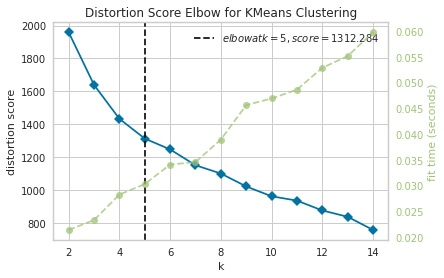

In [134]:
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(2,15))
visualizer.fit(PivotToronto) 
visualizer.show()

In [135]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(PivotToronto)

In [136]:
PivotToronto['Label'] = kmeans.labels_.tolist()
PivotToronto.head()

Venue Category,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Park,Pet Store,Pharmacy,Pizza Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio,Label
District,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
M1C,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
M1E,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
M1H,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


### 4.1 Cluster 0

In [137]:
PivotToronto[ PivotToronto['Label'] == 0 ]

Venue Category,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Park,Pet Store,Pharmacy,Pizza Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio,Label
District,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M2J,1.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,8.0,0.0,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0
M5B,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,3.0,1.0,1.0,3.0,1.0,9.0,0.0,8.0,0.0,3.0,0.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0,3.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,0


### 4.2 Cluster 1

In [138]:
PivotToronto[ PivotToronto['Label'] == 1 ]

Venue Category,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Park,Pet Store,Pharmacy,Pizza Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio,Label
District,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
M1C,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
M1E,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
M1H,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
M1J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
M1K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
M1L,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
M1M,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### 4.3 Cluster 2

In [139]:
PivotToronto[ PivotToronto['Label'] == 2 ]

Venue Category,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Park,Pet Store,Pharmacy,Pizza Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio,Label
District,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M5H,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,5.0,0.0,2.0,0.0,9.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,2.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,2
M5J,0.0,1.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,13.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2
M5K,3.0,1.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7.0,1.0,1.0,0.0,10.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,8.0,1.0,0.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,3.0,1.0,3.0,1.0,2.0,2.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,2
M5L,4.0,1.0,1.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,2.0,12.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,4.0,1.0,6.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,7.0,1.0,1.0,3.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0,1.0,0.0,2
M5X,3.0,1.0,3.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,8.0,0.0,0.0,0.0,10.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,4.0,1.0,5.0,1.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,3.0,1.0,3.0,0.0,0.0,3.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,2


### 4.4 Cluster 3

In [140]:
PivotToronto[ PivotToronto['Label'] == 3 ]

Venue Category,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Park,Pet Store,Pharmacy,Pizza Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio,Label
District,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M2N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
M4G,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
M4K,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,8.0,1.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
M4M,2.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3
M4S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
M4X,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
M5M,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
M5R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
M5S,0.0,0.0,0.0,2.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3


### 4.5 Cluster 4

In [141]:
PivotToronto[ PivotToronto['Label'] == 4 ]

Venue Category,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bank,Bar,Beer Bar,Beer Store,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Fast Food Restaurant,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Liquor Store,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Park,Pet Store,Pharmacy,Pizza Place,Pub,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio,Label
District,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M4Y,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4
M5A,0.0,1.0,1.0,3.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,4
M5C,3.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,0.0,2.0,3.0,5.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,4
M5E,0.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4
M5G,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,4
M5W,1.0,2.0,0.0,2.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,3.0,10.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,3.0,0.0,0.0,3.0,3.0,1.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,3.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,4
M7A,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4


## 5. Conclusion

These are the most common veune in Toronto.

* Coffee Shop
* Restaurant
* Park
* Pizza place
* Italian Restaurant

The analysis results are from analyzing the clustering result from K-means (k=5 which is picked from using the elbow technique). Then, the result will provide outstanding attributes of each cluster